## Module Installation

In [ ]:
!pip install catboost -q
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 76.6 MB 1.3 MB/s 
Mounted at /content/drive


## Importing libraries

In [ ]:
# Dataframe and Plotting libraries
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import imblearn.over_sampling as ovs

from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import *
from sklearn.cluster import KMeans
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
path = '/content/drive/MyDrive/Alvin/'
seed = 21

## 1. Load the dataset

In [ ]:
# Load the files into a Pandas Dataframe
Train = pd.read_csv(path+'Train.csv', parse_dates=['PURCHASED_AT', 'MERCHANT_CATEGORIZED_AT'])
Test = pd.read_csv(path+'Test.csv', parse_dates=['PURCHASED_AT', 'MERCHANT_CATEGORIZED_AT'])
extra = pd.read_csv(path+'extra_data.csv', parse_dates=['PURCHASED_AT', 'MERCHANT_CATEGORIZED_AT'])

In [ ]:
# Let’s observe the shape of our datasets.
print('Train data shape :', Train.shape)
print('Test data shape :', Test.shape)

Train data shape : (373, 12)
Test data shape : (558, 11)


In [ ]:
# Inspect the training data
Train.head()

,MERCHANT_CATEGORIZED_AT,MERCHANT_NAME,MERCHANT_CATEGORIZED_AS,PURCHASE_VALUE,PURCHASED_AT,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_AGE,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,USER_ID,Transaction_ID
0,2022-05-04 10:25:50.588042+00:00,UONSDA CHURCH MOGERE MWAYO TITHE,Rent / Mortgage,1700,2022-05-04 13:56:00+00:00,False,NaN,Male,3,10000,ID_ZX4DCF4K,ID_04mk78fa
1,2021-10-25 16:18:38.586837+00:00,PARK N GO,Transport & Fuel,100,2021-10-24 14:12:00+00:00,False,25.0,Female,4,90000,ID_U9WZMGJZ,ID_04xkfb07
2,2022-05-20 14:17:30.917297+00:00,SAFARICOM OFFERS TUNUKIWA,Data & WiFi,20,2022-05-27 12:46:00+00:00,False,NaN,Male,3,10000,ID_ZX4DCF4K,ID_051urwuw
3,2022-04-12 15:59:14.139347+00:00,ZILLIONS CREDIT LIMITED,Loan Repayment,3800,2022-02-07 12:16:00+00:00,False,NaN,Male,5,252000,ID_3JA0MAFB,ID_0e1om7rz
4,2022-05-04 10:24:26.709045+00:00,MICHAEL MUSEMBI,Bills & Fees,60,2022-05-04 15:28:00+00:00,False,NaN,Male,3,10000,ID_ZX4DCF4K,ID_0kfcoawb


## 2. EDA,Preprocessing and Feature Engineering

### Plots

<BarContainer object of 373 artists>

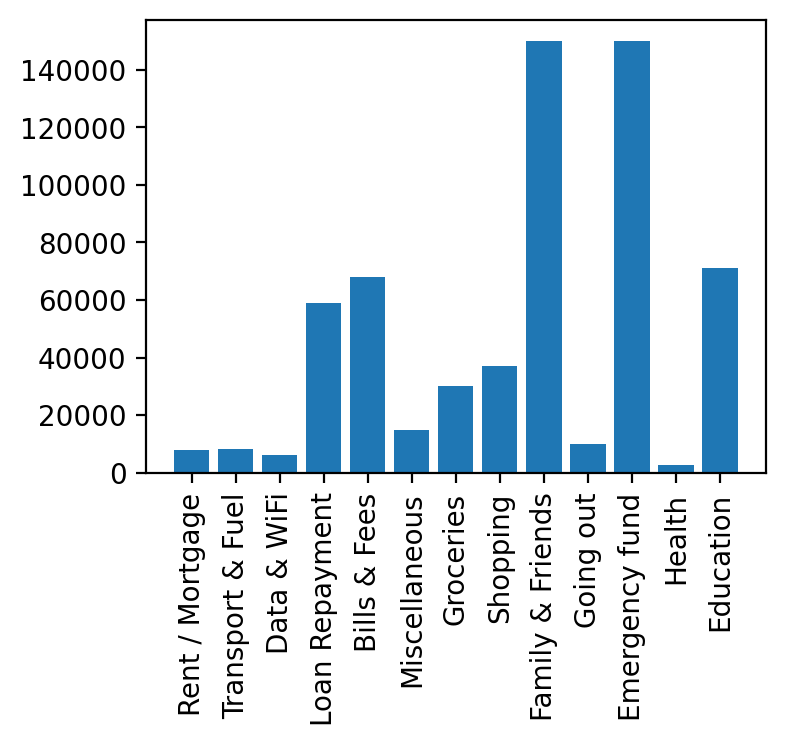

In [ ]:
# Show a bar graph of the purchase_value vs the target in the train data (merchant_categorized_as)
plt.figure(dpi=200, figsize=(4,3))
plt.xticks(rotation=90)
plt.bar(data=Train, x='MERCHANT_CATEGORIZED_AS', height='PURCHASE_VALUE')

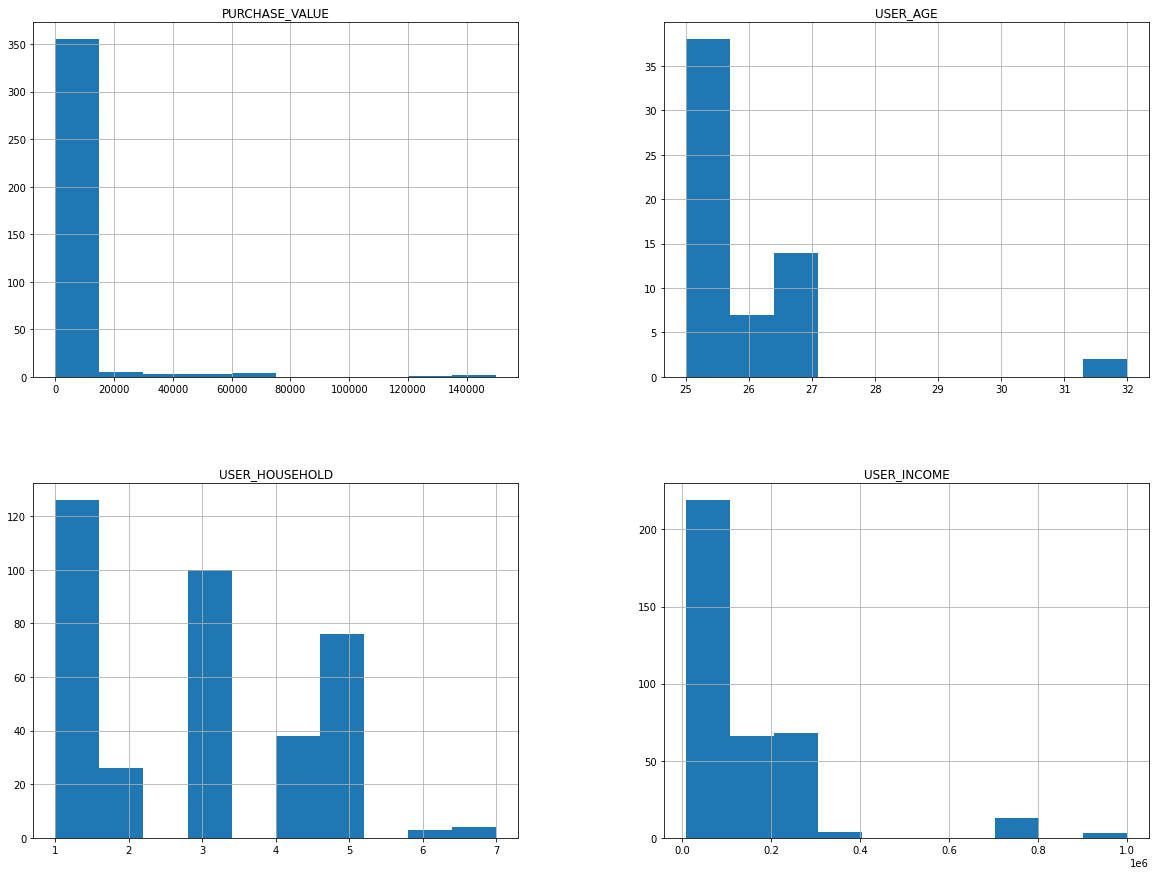

In [ ]:
#Numerical Features Histograms (Train)
num_feats = list(Train.select_dtypes(include=['int64', 'float64', 'int32']).columns)
Train[num_feats].hist(figsize=(20,15));

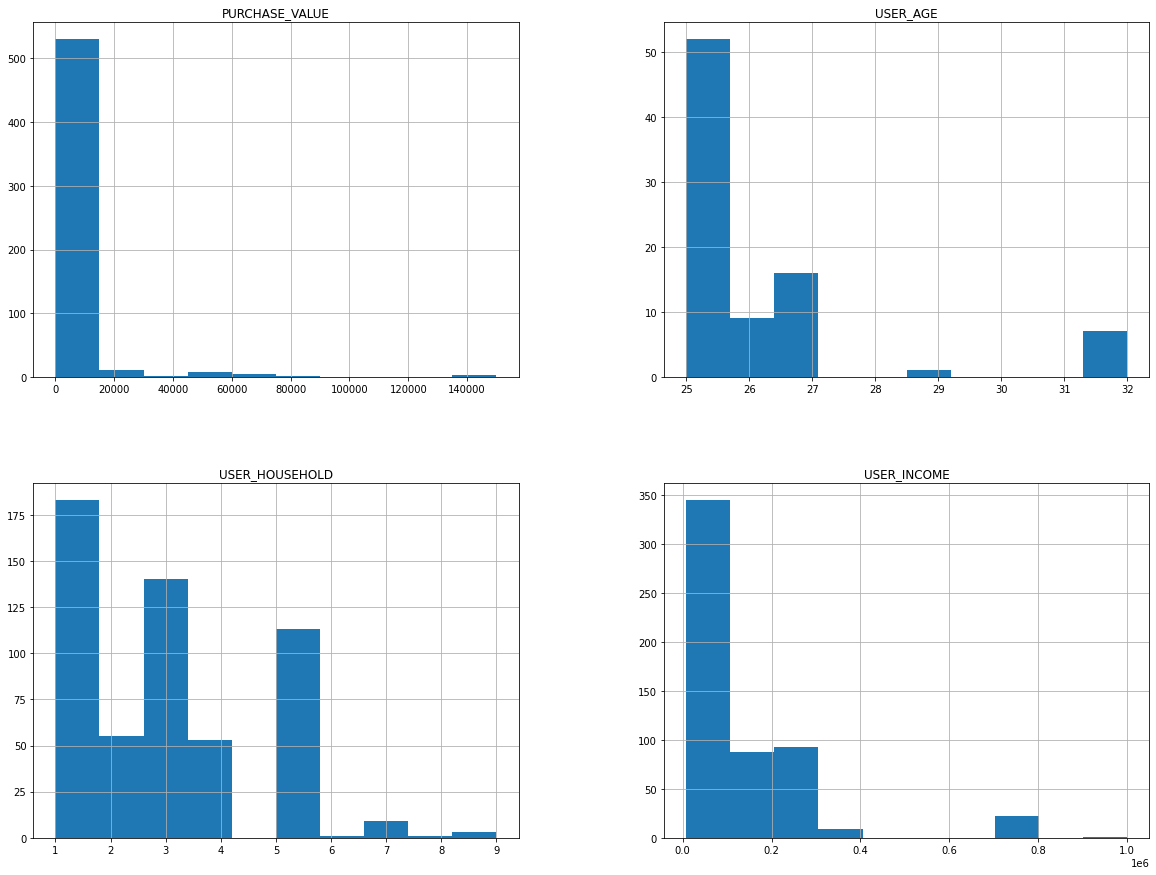

In [ ]:
#Numerical Features Histograms (Test)
num_feats = list(Test.select_dtypes(include=['int64', 'float64', 'int32']).columns)
Test[num_feats].hist(figsize=(20,15));

### Other EDA

In [ ]:
# check the number of users
tr = Train.USER_ID.unique()
ts = Test.USER_ID.unique()
ex = extra.USER_ID.unique()

np.intersect1d(tr, ts).shape, ts.shape, np.intersect1d(ts, ex).shape

((25,), (30,), (28,))

#### Missing values

In [ ]:
# We can also use the .isnull() method to check for empty values
print('Missing values for Train:\n', Train.isnull().sum())
print('')
print('Missing values for Test:\n', Test.isnull().sum())
print()
print('Missing values for Test:\n', extra.isnull().sum())

Missing values for Train:
 MERCHANT_CATEGORIZED_AT                    0
MERCHANT_NAME                              0
MERCHANT_CATEGORIZED_AS                    0
PURCHASE_VALUE                             0
PURCHASED_AT                               0
IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY      0
USER_AGE                                 312
USER_GENDER                                6
USER_HOUSEHOLD                             0
USER_INCOME                                0
USER_ID                                    0
Transaction_ID                             0
dtype: int64

Missing values for Test:
 MERCHANT_CATEGORIZED_AT                    0
MERCHANT_NAME                              0
PURCHASE_VALUE                             0
PURCHASED_AT                               0
IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY      0
USER_AGE                                 473
USER_GENDER                                5
USER_HOUSEHOLD                             0
USER_INCOME                      

In [ ]:
Train['USER_GENDER'].value_counts()

Male      197
Female    170
Name: USER_GENDER, dtype: int64

for the missing data of gender, we can either fill it with either Male or Female since Male has larger value let's fill it with Male.

In [ ]:
Train["USER_GENDER"] = Train["USER_GENDER"].apply(lambda x: "Male" if pd.isna(x) else x)
Test["USER_GENDER"] = Test["USER_GENDER"].apply(lambda x: "Male" if pd.isna(x) else x)

For a baseline lets drop the age column (84% is alot of missing values)

In [ ]:
Train.drop(['USER_AGE'], axis=1, inplace=True)
Test.drop(['USER_AGE'], axis=1, inplace=True)

#### Let's check for duplicates

In [ ]:
Train[Train.duplicated(Train.columns[1:-1].drop('MERCHANT_CATEGORIZED_AS'), keep=False)].sort_values('PURCHASED_AT')

,MERCHANT_CATEGORIZED_AT,MERCHANT_NAME,MERCHANT_CATEGORIZED_AS,PURCHASE_VALUE,PURCHASED_AT,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,USER_ID,Transaction_ID
188,2022-03-16 13:08:19.703288+00:00,JIMMIE WAIRIMU,Bills & Fees,40000,2019-03-11 05:38:00+00:00,True,Female,1,10000,ID_40L9OTIM,ID_irnbaw9h
356,2022-03-16 13:05:51.851102+00:00,JIMMIE WAIRIMU,Bills & Fees,40000,2019-03-11 05:38:00+00:00,True,Female,1,10000,ID_40L9OTIM,ID_yg77gagk
209,2022-03-16 13:08:19.703288+00:00,TELKOM KENYA LIMITED,Data & WiFi,100,2019-06-20 08:41:00+00:00,True,Female,1,85000,ID_1I8XYBWK,ID_knsvgbug
227,2022-03-16 13:05:51.851102+00:00,TELKOM KENYA LIMITED,Data & WiFi,100,2019-06-20 08:41:00+00:00,True,Female,1,85000,ID_1I8XYBWK,ID_ltunpaxl
330,2021-12-01 08:30:46.660752+00:00,SAFARICOM LIMITED,Data & WiFi,500,2021-01-15 15:40:00+00:00,False,Male,3,200000,ID_ECX9BS4A,ID_w12ria65
370,2021-12-01 08:33:13.820670+00:00,SAFARICOM LIMITED,Data & WiFi,500,2021-01-15 15:40:00+00:00,False,Male,3,200000,ID_ECX9BS4A,ID_zx5ajeqe
145,2021-08-06 11:28:16.860332+00:00,JAVA,Going out,880,2021-08-04 15:03:00+00:00,False,Male,3,200000,ID_ECX9BS4A,ID_efpodiwb
327,2021-12-01 08:33:13.820670+00:00,JAVA,Going out,880,2021-08-04 15:03:00+00:00,False,Male,3,200000,ID_ECX9BS4A,ID_vmy2bhah
85,2021-08-06 11:28:03.855344+00:00,MIKE KOECH,Groceries,130,2021-08-24 14:53:00+00:00,True,Female,2,8000,ID_L8QMYB09,ID_8xyhwvvf
335,2021-11-03 14:49:24.056590+00:00,MIKE KOECH,Groceries,130,2021-08-24 14:53:00+00:00,True,Female,2,8000,ID_L8QMYB09,ID_whbkraxr


There are some duplicates in the training data. but at index 186 abd 347 there are two different classification for the same data so we need to drop either of them. since the time for the classification is ealier for index 347 let's drop the 186th row.

In [ ]:
Train = Train.drop(index=186).reset_index(drop=True)
Train.shape

(372, 11)

#### Lets combine all the Train and Test

In [ ]:
# the Transacation ID will be dropped since it has no value
ID = Test['Transaction_ID']
Train["train"] = 1
Test["train"] = 0
Extra = extra.drop(columns=['Transaction_ID', 'USER_AGE'])
all_data = pd.concat([Train, Test])
all_data.drop(['Transaction_ID'], axis=1, inplace=True)

In [ ]:
Train.USER_HOUSEHOLD.describe()[['min', 'max']], Test.USER_HOUSEHOLD.describe()[['min', 'max']]

(min    1.0
 max    7.0
 Name: USER_HOUSEHOLD, dtype: float64, min    1.0
 max    9.0
 Name: USER_HOUSEHOLD, dtype: float64)

since some of users in the test set have more than the maximum train user household that is 7, we set the maximum user household value to 7

In [ ]:
# set max user household value to 7
all_data['USER_HOUSEHOLD'] = all_data['USER_HOUSEHOLD'].apply(lambda x:[x, 7][x>7])

### Feature Engineering

In [ ]:
# let's add price 5 price ranges to the purchase value and apply it to both train_test and extra data
def price_range(x):
    if x > 8e4:
        return 4
    elif x > 4e4:
        return 3
    elif x > 1e4:
        return 2
    elif x <= 100:
        return 1
    return 0

all_data['price_range'] = all_data.PURCHASE_VALUE.apply(price_range)
Extra['price_range'] = Extra.PURCHASE_VALUE.apply(price_range)


In [ ]:
# let's add 4 income ranges to the user income and apply it to both train_test and extra data
def income_range(x):
    x /= 1e6
    if x > .08:
        return 3
    elif x > .04:
        return 2
    elif x > .015:
        return 1
    return 0
all_data['income_range'] = all_data.USER_INCOME.apply(income_range)
Extra['income_range'] = Extra.USER_INCOME.apply(income_range)

other features

In [ ]:
# purcahse value to income ratio
all_data['prod_PURCHASE_INCOME'] = all_data['PURCHASE_VALUE'] / all_data['USER_INCOME'] 
# user income to user household ratio
all_data['income_distribution'] = all_data['USER_INCOME'] / all_data['USER_HOUSEHOLD']

# user types
all_data['user_single'] = (all_data.USER_HOUSEHOLD == 1).astype(int) # single user
all_data['user_couple'] = (all_data.USER_HOUSEHOLD == 2).astype(int) # couple user

count encoding for some features

In [ ]:
col = ['PURCHASE_VALUE','USER_INCOME','USER_HOUSEHOLD','MERCHANT_NAME']

for i in col:
    all_data['count_'+i] = all_data[i].map(all_data[i].value_counts())

all_data.head(2)

,MERCHANT_CATEGORIZED_AT,MERCHANT_NAME,MERCHANT_CATEGORIZED_AS,PURCHASE_VALUE,PURCHASED_AT,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,USER_ID,train,price_range,income_range,prod_PURCHASE_INCOME,income_distribution,user_single,user_couple,count_PURCHASE_VALUE,count_USER_INCOME,count_USER_HOUSEHOLD,count_MERCHANT_NAME
0,2022-05-04 10:25:50.588042+00:00,UONSDA CHURCH MOGERE MWAYO TITHE,Rent / Mortgage,1700,2022-05-04 13:56:00+00:00,False,Male,3,10000,ID_ZX4DCF4K,1,0,0,0.170000,3333.333333,0,0,4,188,240,1
1,2021-10-25 16:18:38.586837+00:00,PARK N GO,Transport & Fuel,100,2021-10-24 14:12:00+00:00,False,Female,4,90000,ID_U9WZMGJZ,1,1,3,0.001111,22500.000000,0,0,78,90,91,2


#### Let's combine the all_data with extra for further feature engineering

In [ ]:
data = pd.concat([all_data.assign(ind="data"), Extra.assign(ind="extra")])
data.shape

(10930, 22)

##### MERCHANT_CLUSTERING

What we want to do is through domain knowledge cluster the merchant into various known categories eg education and health using known terminologies frequently associated with them. We clean data that does not represent well. For example, a merchant with the name school in it, you may well think 100% that falls in the education category but then has cafeteria in it. Most of the time the cafeteria bills are not paid in fees. You pay them personaly e.g campus cafeteria so that does not represent the education field well. Then group by that and find the price range(purchase value) min, max and mean associated with them. We do this in both extra and train to get a good representation of all the data and this proved very very very useful.All unknown and unambiguous merchants in train are filled with a new category. 

###### DATA_WIFI
* Its obvious each country have telcos that lead in data provision and through domain knowledge the below are the most common terms associated with data and wifi and remember we also have extra so i think we should concat them all so that we have a whole representations of all the available merchant names available for training

In [ ]:
data_wifi = data.loc[data['MERCHANT_NAME'].str.contains(
    "wifi|data|safaricom|tunukiwa|zuku|faiba|airtel|telkom|airtime|bundle|poa",
     case=False)]
print(data_wifi.MERCHANT_NAME.nunique())
data_wifi.MERCHANT_CATEGORIZED_AS.value_counts()

26


Data & WiFi         40
Miscellaneous        3
Bills & Fees         2
Health               1
Family & Friends     1
Name: MERCHANT_CATEGORIZED_AS, dtype: int64

In [ ]:
data_wifi.MERCHANT_NAME.unique()

array(['SAFARICOM OFFERS  TUNUKIWA', 'SAFARICOM LIMITED',
       'SAFARICOM POST', 'SAFARICOM POST PAID', 'SAFARICOM HOME',
       'MYAIRTIME LIMITED', 'SAFARICOM POSTPAID', 'TELKOM KENYA LIMITED',
       'POA', 'ZUKU  FOR', 'SAFARICOM POSTPAID BUNDLES',
       'SAFARICOM OFFERS', 'SAFARICOM LIMITED  ON', 'ZUKU',
       'SAFARICOM OFFERS   TUNUKIWA ON', 'SAFARICOM OFFERS  TUNUKIWA ON',
       'SAFARICOM SACCO DEPOSIT CONTRIBUTION',
       'SAFARICOM POSTPAID BUNDLES  BUNDLES', 'SAFARICOM TEST',
       'WIFI GURU LIMITED  B61', 'SAFARICOM RETAIL BURUBURU',
       'HOSTPOA ONLINE SOLUTIONS', 'SAFARICOM RETAIL GALLERIA MALL',
       'SAFARICOM WI-FI ZONE', 'SAFARICOM RETAIL MOI AVE',
       'MAWINGU AIRTIME LIMITED'], dtype=object)

###### HEALTH
* Kenya is an english and kiswahili speaking country so most of the common words used in health care are the ones show below 

In [ ]:
health_related = data.loc[data['MERCHANT_NAME'].str.contains(
    "health|medic|hosp|chemist|pharma|clinic|dr |nhif|dawa|afya",
     case=False)]
print(health_related.MERCHANT_NAME.nunique())
health_related.MERCHANT_CATEGORIZED_AS.value_counts()

116


Health              4
Bills & Fees        2
Family & Friends    1
Name: MERCHANT_CATEGORIZED_AS, dtype: int64

In [ ]:
# lets exclude alchemist - alchemist is a bar/chill place in kenya
health_related = health_related[health_related["MERCHANT_NAME"].str.contains("alchemist", case=False) == False]

###### FUEL and Transport Related
* There are companies that specifically deal with fuel and the common names are shown below
* plus add other terms associated with transport sector
* but here most of the petrol stations are usually associated with places to eat e.g kfc, pizza in, chicken in, coffeeshops and shops so you might want to clean those 

In [ ]:
fuel_related = data.loc[data['MERCHANT_NAME'].str.contains(
    "rubis|total|ola |shell|gas|petro|oilibya|petrol|oil|car |park|jet|energy|auto|motor|engen|aviation|sgr",
     case=False)]
print(fuel_related.MERCHANT_NAME.nunique())
fuel_related.MERCHANT_CATEGORIZED_AS.value_counts()

202


Transport & Fuel    17
Going out            3
Miscellaneous        2
Groceries            2
Loan Repayment       1
Bills & Fees         1
Shopping             1
Name: MERCHANT_CATEGORIZED_AS, dtype: int64

In [ ]:
fuel_related[fuel_related.MERCHANT_CATEGORIZED_AS == "Miscellaneous"]

,MERCHANT_CATEGORIZED_AT,MERCHANT_NAME,MERCHANT_CATEGORIZED_AS,PURCHASE_VALUE,PURCHASED_AT,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,USER_ID,train,price_range,income_range,prod_PURCHASE_INCOME,income_distribution,user_single,user_couple,count_PURCHASE_VALUE,count_USER_INCOME,count_USER_HOUSEHOLD,count_MERCHANT_NAME,ind
59,2022-05-31 13:27:55.175840+00:00,TOTALENERGIES KITISURU,Miscellaneous,1000,2022-05-30 11:29:00+00:00,False,Male,5,150000,ID_O8P8YS18,1.0,0,3,0.006667,30000.0,0.0,0.0,47.0,42.0,189.0,3.0,data
247,2022-05-31 13:21:55.629867+00:00,KAPS PARKING,Miscellaneous,100,2022-05-14 19:00:00+00:00,False,Female,1,23000,ID_Y0386AT9,1.0,1,1,0.004348,23000.0,1.0,0.0,78.0,51.0,308.0,15.0,data


In [ ]:
# lets exclude some of the names
fuel_related = fuel_related[fuel_related["MERCHANT_NAME"].str.contains(
    "kfc|enjoy|caffe|java|pizza|chicken|brioche|shop|mart|club|mogo|planet|pharma|chemist|rivers|fruits|creamy|holdings|estim",
     case=False) == False]
print(fuel_related.shape)
fuel_related.MERCHANT_CATEGORIZED_AS.value_counts()

(452, 22)


Transport & Fuel    17
Miscellaneous        2
Bills & Fees         1
Shopping             1
Going out            1
Groceries            1
Name: MERCHANT_CATEGORIZED_AS, dtype: int64

###### business related
* Each country has big shoppping centres so its the same here big names include the names shown below
* Also its easy to identify shops by using the name shops in the name because most small merchants use shops in their name
* butcheries its also easier to identify them since most of them end with butchery
* We also have markets where people go to buy groceries and more
* Online shops such as Jumia and kilimall are also not left behind

In [ ]:
shopping_related = data.loc[data['MERCHANT_NAME'].str.contains(
    "naivas |tuskys|mart |market|mall|supermarket|naivas|uchumi|carrefour|clean shelf|bata|shop|butchery|hardware|jumia|kilimall|stores|quick",
     case=False)]
print(shopping_related.MERCHANT_NAME.nunique())
shopping_related.MERCHANT_CATEGORIZED_AS.value_counts()

316


Groceries           18
Shopping             8
Going out            3
Bills & Fees         2
Family & Friends     1
Transport & Fuel     1
Miscellaneous        1
Name: MERCHANT_CATEGORIZED_AS, dtype: int64

In [ ]:
shopping_related[shopping_related.MERCHANT_CATEGORIZED_AS == "Miscellaneous"]

,MERCHANT_CATEGORIZED_AT,MERCHANT_NAME,MERCHANT_CATEGORIZED_AS,PURCHASE_VALUE,PURCHASED_AT,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,USER_ID,train,price_range,income_range,prod_PURCHASE_INCOME,income_distribution,user_single,user_couple,count_PURCHASE_VALUE,count_USER_INCOME,count_USER_HOUSEHOLD,count_MERCHANT_NAME,ind
292,2022-06-01 10:25:16.713100+00:00,RIO GIFT SHOP,Miscellaneous,2500,2022-06-06 10:45:00+00:00,False,Female,1,23000,ID_Y0386AT9,1.0,0,1,0.108696,23000.0,1.0,0.0,3.0,51.0,308.0,2.0,data


###### Restaurants, Hotels, Bars and Lounges 
* Includes every place where people go to eat
* We start from normal hotels, restaurants, lounges to high end ones as shown below

In [ ]:
hotel_related = data.loc[data['MERCHANT_NAME'].str.contains(
    "hotel|restaurant|dishes|grill|lunch|bar|pub|bar |lounge|java|caffe|kfc|pizza|chicken|fish|\
    lounge|latte|club|inn|resort|brioche|alchemist|planet|creamy|gardens|recreation",
     case=False)]
print(hotel_related.MERCHANT_NAME.nunique())
hotel_related.MERCHANT_CATEGORIZED_AS.value_counts()

363


Going out    18
Groceries     3
Shopping      1
Name: MERCHANT_CATEGORIZED_AS, dtype: int64

In [ ]:
hotel_related[hotel_related.MERCHANT_CATEGORIZED_AS == "Groceries"]

,MERCHANT_CATEGORIZED_AT,MERCHANT_NAME,MERCHANT_CATEGORIZED_AS,PURCHASE_VALUE,PURCHASED_AT,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,USER_ID,train,price_range,income_range,prod_PURCHASE_INCOME,income_distribution,user_single,user_couple,count_PURCHASE_VALUE,count_USER_INCOME,count_USER_HOUSEHOLD,count_MERCHANT_NAME,ind
83,2022-03-16 13:08:19.703288+00:00,MBAIRES RESTAURANT 6,Groceries,1520,2021-06-20 11:36:00+00:00,False,Male,5,750000,ID_D8FOVVBB,1.0,0,3,0.002027,150000.0,0.0,0.0,1.0,35.0,189.0,1.0,data
118,2022-03-16 13:08:19.703288+00:00,THE SPOT POOL BAR,Groceries,300,2022-02-04 06:33:00+00:00,False,Male,1,200000,ID_5Y35KI6Q,1.0,0,3,0.001500,200000.0,1.0,0.0,46.0,112.0,308.0,1.0,data
213,2022-03-16 13:07:12.505595+00:00,FISH BAY,Groceries,430,2022-03-30 11:04:00+00:00,False,Male,1,200000,ID_5Y35KI6Q,1.0,0,3,0.002150,200000.0,1.0,0.0,3.0,112.0,308.0,2.0,data


###### SCHOOL RELATED 
* Globally and locally there are specific names associated with schools and fees as shown below 
* Some parts of the schools like cafeteria may not well depict the financial aspect on schools like fees so drop them


In [ ]:
school_related = data.loc[data['MERCHANT_NAME'].str.contains(
    "school|university|campus|college|fees|karo |polytechnic|cbf|kindergarten",
     case=False)]

print(school_related.MERCHANT_NAME.nunique())
school_related.MERCHANT_CATEGORIZED_AS.value_counts()

14


Education    2
Name: MERCHANT_CATEGORIZED_AS, dtype: int64

In [ ]:
school_related.MERCHANT_NAME.unique()

array(['LIPA KARO KCB ACCOUNT', 'CITAM BUSINESS FORUM   CBF ON',
       'TRINITY INRENATIONAL KINDERGARTEN LTD VIA SCB  TEMI MBARI',
       'STRATHMORE BUSINESS SCHOOL', 'SCHOOL PHOTOS-KILELESHWA',
       'AGA KHAN UNIVERSITY HOSPITAL NBI INPATIENT BILLS  CASUALTYPZP',
       'AGA KHAN UNIVERSITY HOSPITAL NBI PEDIATRIC CASUALTY',
       'HEART TO HEART FOUNDATION  MIKISA SCHOOL',
       'UNIVERSITY OF NAIROBI-EXAMINATION',
       'KENYA SCHOOL OF LAW-STUDENT CAFETERIA',
       'UNIVERSITY OF NAIROBI - CHSS VIA ABSA',
       'AGA KHAN UNIVERSITY HOSPITAL - RUAKA MEDICAL CENTRE',
       'MORINGA SCHOOL LIMITED', 'MIATHENE BOYS SECONDARY SCHOOL VIA NBK'],
      dtype=object)

In [ ]:
school_related = school_related[school_related["MERCHANT_NAME"].str.contains("cafeteria|hospital", case=False) == False]

In [ ]:
school_related.MERCHANT_NAME.unique()

array(['LIPA KARO KCB ACCOUNT', 'CITAM BUSINESS FORUM   CBF ON',
       'TRINITY INRENATIONAL KINDERGARTEN LTD VIA SCB  TEMI MBARI',
       'STRATHMORE BUSINESS SCHOOL', 'SCHOOL PHOTOS-KILELESHWA',
       'HEART TO HEART FOUNDATION  MIKISA SCHOOL',
       'UNIVERSITY OF NAIROBI-EXAMINATION',
       'UNIVERSITY OF NAIROBI - CHSS VIA ABSA', 'MORINGA SCHOOL LIMITED',
       'MIATHENE BOYS SECONDARY SCHOOL VIA NBK'], dtype=object)

###### Finance Related 
* Here we use banks, loan apps, credit institutions and investments
* Remove all names with paybill because most of the time paybill is for normal expenditures

In [ ]:
finance_related = data.loc[data['MERCHANT_NAME'].str.contains(
    "bank|loan|credit|insur|kcb|equity|ncba|barclays|coop|CO-OP|standard chartered|mshwari|m-shwari|zenka|tala|stanbic|saving|invest|\
    capital|trust|retirement|pension|xgo|bayes|mogo|sacco|holdings|ncba|kandamoja|cash|m-kopa|mkopa|kopa|enterprise|kra",
     case=False)]

print(finance_related.MERCHANT_NAME.nunique())
finance_related.MERCHANT_CATEGORIZED_AS.value_counts()

245


Bills & Fees        15
Emergency fund       8
Loan Repayment       5
Groceries            5
Transport & Fuel     4
Shopping             2
Education            1
Rent / Mortgage      1
Family & Friends     1
Name: MERCHANT_CATEGORIZED_AS, dtype: int64

In [ ]:
finance_related[finance_related['MERCHANT_CATEGORIZED_AS'] == 'Groceries']

,MERCHANT_CATEGORIZED_AT,MERCHANT_NAME,MERCHANT_CATEGORIZED_AS,PURCHASE_VALUE,PURCHASED_AT,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,USER_ID,train,price_range,income_range,prod_PURCHASE_INCOME,income_distribution,user_single,user_couple,count_PURCHASE_VALUE,count_USER_INCOME,count_USER_HOUSEHOLD,count_MERCHANT_NAME,ind
14,2022-03-16 13:08:19.703288+00:00,GARIDON ENTERPRISES VIA CO-OP,Groceries,4090,2020-12-28 13:29:00+00:00,False,Female,1,250000,ID_OZANC6XT,1.0,0,3,0.016360,250000.0,1.0,0.0,1.0,39.0,308.0,1.0,data
36,2022-05-31 13:27:24.704992+00:00,KCB PAYBILL AC,Groceries,300,2022-05-31 12:04:00+00:00,False,Female,1,23000,ID_Y0386AT9,1.0,0,1,0.013043,23000.0,1.0,0.0,46.0,51.0,308.0,7.0,data
56,2022-05-31 13:22:16.049027+00:00,EQUITY PAYBILL ACCOUNT,Groceries,600,2022-05-31 17:02:00+00:00,True,Female,1,23000,ID_Y0386AT9,1.0,0,1,0.026087,23000.0,1.0,0.0,9.0,51.0,308.0,19.0,data
333,2022-03-16 13:08:19.703288+00:00,KEMAHMWA ENTERPRISE HQ,Groceries,180,2022-04-01 06:08:00+00:00,False,Female,1,250000,ID_OZANC6XT,1.0,0,3,0.000720,250000.0,1.0,0.0,1.0,39.0,308.0,3.0,data
354,2022-03-16 13:08:19.703288+00:00,KEMAHMWA ENTERPRISE HQ,Groceries,80,2022-03-31 05:48:00+00:00,False,Female,1,250000,ID_OZANC6XT,1.0,1,3,0.000320,250000.0,1.0,0.0,8.0,39.0,308.0,3.0,data


In [ ]:
finance_related = finance_related[finance_related["MERCHANT_NAME"].str.contains("karo|paybill", case=False) == False]

In [ ]:
finance_related.MERCHANT_CATEGORIZED_AS.value_counts()

Bills & Fees        10
Emergency fund       6
Loan Repayment       5
Transport & Fuel     4
Groceries            3
Rent / Mortgage      1
Family & Friends     1
Name: MERCHANT_CATEGORIZED_AS, dtype: int64

###### Mode of Payment 
* the likes of paybills, paypal, pesa pap,direct pay, crypto and more

In [ ]:
payment_related = data.loc[data['MERCHANT_NAME'].str.contains("crypto|bitcoin|paybill|pesa|ipay|paytech", case=False)]
print(payment_related.MERCHANT_NAME.nunique())
payment_related.MERCHANT_CATEGORIZED_AS.value_counts()

40


Bills & Fees        6
Groceries           2
Shopping            2
Data & WiFi         2
Emergency fund      2
Transport & Fuel    2
Going out           1
Family & Friends    1
Name: MERCHANT_CATEGORIZED_AS, dtype: int64

In [ ]:
payment_related = payment_related[payment_related["MERCHANT_NAME"].str.contains("mpesa|m-pesa", case=False) == False]

In [ ]:
payment_related.MERCHANT_NAME.unique()

array(['KCB PAYBILL AC', 'EQUITY PAYBILL ACCOUNT', 'IPAY LTD', 'PESAPAL',
       'PESAPAL  FOR', 'PAYTECH -THE JUNCTION MALL', 'PAYTECH LIMITED',
       'EQUITY PAYBILL', 'FAMILY BANK PESA PAP', 'KCB PAYBILL', 'PAYTECH',
       'PESAPAL SABI', 'PAYTECH A  THE HUB KAREN', 'PESAPAL LIMITED',
       'PESAPAL ON', 'PESAPAL 9', 'PAYTECH -SARIT CENTER',
       'PAYTECH WETSGATE', 'PESAPAL   ON', 'PESAPAL II',
       'BIASHARA PAYBILL VIA FAMILY BANK  TERKI',
       'BIASHARA PAYBILL VIA FAMILY BANK  MANIA',
       'PARKLANDS SPORTS CLUB PAYBILL  N95',
       'PARKLANDS SPORTS CLUB PAYBILL  N94',
       'PARKLANDS SPORTS CLUB PAYBILL  R27',
       'PARKLANDS SPORTS CLUB PAYBILL', 'IPAY LTD  WEST',
       'PAYTECH -THE JUNCTION MALL  KDA', 'BAYES COLLECTIONS PAYBILL',
       'IPAY LTD  RAFU', 'PESAPAL  2',
       'JUDICIARY PAYBILL VIA KCB  EZER6PLK',
       'JUDICIARY PAYBILL VIA KCB  EZFBM6AK',
       'JUDICIARY PAYBILL VIA KCB  EZCYR4GJ', 'SPORTPESA  SPORTPESA',
       'SPORTPESA'], dtype=o

###### Bills related 
* water,rent,trash,power

In [ ]:
bills_related = data.loc[data['MERCHANT_NAME'].str.contains("rent|apartment|water|kplc|trash|bins", case=False)]
print(bills_related.MERCHANT_NAME.nunique())
bills_related.MERCHANT_CATEGORIZED_AS.value_counts()

20


Bills & Fees    10
Name: MERCHANT_CATEGORIZED_AS, dtype: int64

In [ ]:
bills_related = bills_related[bills_related["MERCHANT_NAME"].str.contains("bar|front|pub", case=False) == False]

In [ ]:
bills_related.MERCHANT_CATEGORIZED_AS.value_counts()

Bills & Fees    10
Name: MERCHANT_CATEGORIZED_AS, dtype: int64

###### Others
* These includes things like tithes and offerings, and church development fees, ecitizen, county goverment payments and more


In [ ]:
others_related = data.loc[data['MERCHANT_NAME'].str.contains(
    "church|offerin|tithe|kanisa|sadaka|fungu|county|citizen|kra|association|sportpesa",
     case=False)]
print(others_related.MERCHANT_NAME.nunique())
others_related.MERCHANT_CATEGORIZED_AS.value_counts()

78


Miscellaneous       2
Rent / Mortgage     1
Transport & Fuel    1
Bills & Fees        1
Name: MERCHANT_CATEGORIZED_AS, dtype: int64

In [ ]:
others_related[others_related['MERCHANT_CATEGORIZED_AS'] == 'Rent / Mortgage']

,MERCHANT_CATEGORIZED_AT,MERCHANT_NAME,MERCHANT_CATEGORIZED_AS,PURCHASE_VALUE,PURCHASED_AT,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,USER_ID,train,price_range,income_range,prod_PURCHASE_INCOME,income_distribution,user_single,user_couple,count_PURCHASE_VALUE,count_USER_INCOME,count_USER_HOUSEHOLD,count_MERCHANT_NAME,ind
0,2022-05-04 10:25:50.588042+00:00,UONSDA CHURCH MOGERE MWAYO TITHE,Rent / Mortgage,1700,2022-05-04 13:56:00+00:00,False,Male,3,10000,ID_ZX4DCF4K,1.0,0,0,0.17,3333.333333,0.0,0.0,4.0,188.0,240.0,1.0,data


How can a tithe be categorized as rent/mortgage most definitely an outlier

In [ ]:
others_related = others_related[others_related["MERCHANT_NAME"].str.contains("auto|level", case=False) == False]

###### Adding the bins to the data

In [ ]:
# fetch the merchant names from the clustered dataframes

data_wifi = data_wifi.MERCHANT_NAME.unique()
health_related = health_related.MERCHANT_NAME.unique()
fuel_related = fuel_related.MERCHANT_NAME.unique()
shopping_related = shopping_related.MERCHANT_NAME.unique()
hotel_related = hotel_related.MERCHANT_NAME.unique()
school_related = school_related.MERCHANT_NAME.unique()
finance_related = finance_related.MERCHANT_NAME.unique()
payment_related = payment_related.MERCHANT_NAME.unique()
bills_related = bills_related.MERCHANT_NAME.unique()
others_related = others_related.MERCHANT_NAME.unique()


def merch_bin(x):
    bases = [data_wifi, health_related, fuel_related, shopping_related, hotel_related, 
    school_related, finance_related, bills_related, others_related]
    for i, cla in enumerate(bases):
        if x in cla:
            return i 
    return 9 # if not found in the classes assign it as others

# lets add the clusters to the data
data['MERCHANT_NAME_bin'] = data['MERCHANT_NAME'].apply(merch_bin)

##### Aggregate Features


lets add aggregate values of the purchase value and income of the user by grouping the data by the bins




In [ ]:
merch_bin_groups = data.groupby('MERCHANT_NAME_bin').agg(


             purchase_merch_bin_min = ("PURCHASE_VALUE", "min"),
             purchase_merch_bin_max = ("PURCHASE_VALUE", "max"),        
             purchase_merch_bin_sum = ("PURCHASE_VALUE", "sum"),
             purchase_merch_bin_mean = ("PURCHASE_VALUE", "mean"),
             purchase_merch_bin_count = ("PURCHASE_VALUE", "count"),
    
             income_merch_bin_min = ("USER_INCOME", "min"),
             income_merch_bin_max = ("USER_INCOME", "max"),        
             income_merch_bin_sum = ("USER_INCOME", "sum"),
             income_merch_bin_mean = ("USER_INCOME", "mean"),
    
             ).reset_index()

data = pd.merge(data, merch_bin_groups, on=['MERCHANT_NAME_bin'], how ='left')

lets add aggregate values of the purchase value and income of the user by grouping the data by the MERCHANT_NAME

In [ ]:
merch_groups = data.groupby('MERCHANT_NAME').agg(


             purchase_merch_min = ("PURCHASE_VALUE", "min"),
             purchase_merch_max = ("PURCHASE_VALUE", "max"),        
             purchase_merch_sum = ("PURCHASE_VALUE", "sum"),
             purchase_merch_mean = ("PURCHASE_VALUE", "mean"),
             purchase_merch_count = ("PURCHASE_VALUE", "count"),
    
             income_merch_min = ("USER_INCOME", "min"),
             income_merch_max = ("USER_INCOME", "max"),        
             income_merch_sum = ("USER_INCOME", "sum"),
             income_merch_mean = ("USER_INCOME", "mean"),
    
             ).reset_index()

data = pd.merge(data, merch_groups,on=['MERCHANT_NAME'], how ='left')

Separte the data from extra data

In [ ]:
all_data, Extra = data[data["ind"].eq("data")], data[data["ind"].eq("extra")]
all_data = all_data.drop(columns = ['ind'])

all_data.shape

(930, 40)

#### More feature engineering

##### Date features

In [ ]:
# change the column MERCHANT_CATEGORIZED_AT to datetime format
all_data.MERCHANT_CATEGORIZED_AT = pd.to_datetime(all_data.MERCHANT_CATEGORIZED_AT)

In [ ]:
# add the day, month, dayofweek, hour and quarter date  features for PURCHASED_AT column
dt_ft = ['day', 'month', 'dayofweek', 'hour', 'quarter']
for ft in dt_ft:
    exec(f'all_data["PURCHASED_AT_{ft}"] = all_data.PURCHASED_AT.dt.{ft}.astype(str)')

# add the day, month, and hour  features for MERCHANT_CATEGORIZED_AT column
dt_ft = ['day', 'month', 'hour']
for ft in dt_ft:
    exec(f'all_data["MERCHANT_CATEGORIZED_AT_{ft}"] = all_data.MERCHANT_CATEGORIZED_AT.dt.{ft}')

In [ ]:
def hour_cluster(x):
    x = int(x)
    if (x > 4) and (x <= 8):
        return 0
    elif (x > 8) and (x <= 12 ):
        return 1
    elif (x > 12) and (x <= 16):
        return 2
    elif (x > 16) and (x <= 20) :
        return 3
    elif (x > 20) and (x <= 24):
        return 4
    elif (x <= 4):
        return 5

# cluster the Purchasing hours to 6 classes
all_data['PURCHASED_AT_hour'] = all_data['PURCHASED_AT_hour'].apply(hour_cluster)

##### Feature Combination

In [ ]:
fts_to_be_combined = [
    ('IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY', 'price_range'),
    ('IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY', 'PURCHASED_AT_quarter'),
    ('IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY', 'PURCHASED_AT_dayofweek'),
    ('IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY', 'PURCHASED_AT_day'),
    ('IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY', 'PURCHASED_AT_hour'),
    ('IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY', 'MERCHANT_NAME_bin'),
    ('price_range', 'PURCHASED_AT_quarter'),
    ('price_range', 'PURCHASED_AT_dayofweek'),
    ('price_range', 'PURCHASED_AT_quarter'),
    ('price_range', 'PURCHASED_AT_hour'),
    ('price_range', 'USER_GENDER'),
    ('USER_GENDER', 'USER_HOUSEHOLD'),
]

for ft1, ft2 in fts_to_be_combined:
    all_data[f'{ft1}_{ft2}'] = all_data[ft1].astype(str) + all_data[ft2].astype(str)

##### Automatic clustring of MERCHANT_NAME

(930, 648)


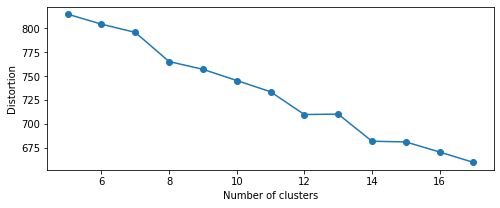

In [ ]:
# CountVectorizer with 2 words
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(2, 2))

X_v = vectorizer.fit_transform(all_data.MERCHANT_NAME)
print(X_v.shape)


distortions = []
R = range(5, 18)
for i in R:
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=32, max_iter=1000,
        tol=1e-04, random_state=0
    )
    km.fit(X_v)
    distortions.append(km.inertia_)

# plot
plt.figure(figsize=(8,3))
plt.plot(R, distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

as we can see from the plot 14 classes gives relatively lower loss

In [ ]:
classes = 14
km = KMeans(
        n_clusters=classes, init='k-means++',
        n_init=32, max_iter=1000,
        tol=1e-04, random_state=0
    )
km.fit(X_v)
trans = km.predict(X_v)
all_data[f'merchant_vectorizer'] = trans

(930, 1793)


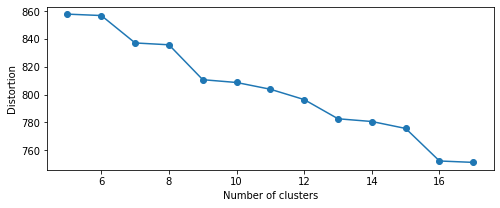

In [ ]:
# words starting from length 1
vectorizer = TfidfVectorizer(ngram_range=(1, 4))

X_v = vectorizer.fit_transform(all_data.MERCHANT_NAME)
print(X_v.shape)

distortions = []
R = range(5, 18)
for i in R:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=4, max_iter=1000,
        tol=1e-04, random_state=0
    )
    km.fit(X_v)
    distortions.append(km.inertia_)

# plot
plt.figure(figsize=(8,3))
plt.plot(R, distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

as we can see from the plot 16 classes gives relatively lower loss

In [ ]:
classes = 16
km = KMeans(
        n_clusters=classes, init='k-means++',
        n_init=20, max_iter=1000,
        tol=1e-04, random_state=seed
    )
km.fit(X_v)
trans = km.predict(X_v)
all_data['merchant_vectorizer2'] = trans

##### Decomposition of features
let's add the decomposed features of the aggregate features that were calculated from the MERCHANT_NAME

In [ ]:
agg_cols = [i for i in all_data.columns if '_merch_' in i and 'bin' not in i]
print(len(agg_cols))
agg_cols

9


['purchase_merch_min',
 'purchase_merch_max',
 'purchase_merch_sum',
 'purchase_merch_mean',
 'purchase_merch_count',
 'income_merch_min',
 'income_merch_max',
 'income_merch_sum',
 'income_merch_mean']

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# add decompose the 9 features to 4 features
transformed = PCA(n_components=4, random_state=0).fit_transform(
    StandardScaler().fit_transform(all_data[agg_cols])
    )

for i in range(transformed.shape[1]):
    all_data[f'pca_ft_{i+1}'] = transformed[:, i]

### Processing

In [ ]:
# since we generated the date features from it let's drop them
all_data.drop(['MERCHANT_CATEGORIZED_AT','PURCHASED_AT'], axis=1, inplace=True)

Dummy values for IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY and USER_GENDER

In [ ]:
all_data = pd.get_dummies(all_data, columns=['IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY', 'USER_GENDER'])

Label Encoding for categorical columns

In [ ]:
cat_fts = [c for c in all_data.select_dtypes(include=['bool', 'object']).columns if c != 'MERCHANT_CATEGORIZED_AS']

le = LabelEncoder()
for ft in cat_fts:
    all_data[ft] = le.fit_transform(all_data[ft])

Separate train and test from all_data

In [ ]:
train_df = all_data[all_data["train"] == 1].drop(["train"], axis=1)
test_df = all_data[all_data["train"] == 0].drop(["train", 'MERCHANT_CATEGORIZED_AS'], axis=1)

In [ ]:
print("Train: ", train_df.shape)
print("Test: ", test_df.shape)

Train:  (372, 64)
Test:  (558, 63)


## 3. Modeling




In [ ]:
# Separate the features from the target in the training data

main_cols = train_df.columns.difference([
    'MERCHANT_CATEGORIZED_AS',
    'purchase_merch_max', 'purchase_merch_sum', 'purchase_merch_mean', 'purchase_merch_count', 
    'income_merch_min', 'income_merch_max', 'income_merch_sum', 'income_merch_mean',
    ])

labels_train = Train['MERCHANT_CATEGORIZED_AS'].astype('category').cat.categories.tolist()
lab_map = dict(zip(labels_train, range(len(labels_train))))

X = train_df[main_cols]
y = train_df["MERCHANT_CATEGORIZED_AS"].map(lab_map)
test = test_df[main_cols]

X.shape, test.shape

((372, 55), (558, 55))

Apply SMOTE to overcome the imbalance

In [ ]:
oversample = ovs.SMOTE(k_neighbors=1, random_state=0)
X, y = oversample.fit_resample(X, y)

## 4. Model Building and Experiments



### 4.1 1st level

#### Splitted predictions

In [ ]:
# class for training more than one models and averging the results
class My_model:
    def __init__(self, models):
        self.models = models

    def fit_eval_pred(self, X, y, eval_set, val, test, verbose=True):
        results_eval = []
        results_test = []
        for i, model in enumerate(self.models):
            if verbose:
                print(f"[Training]............................... Model_{i+1}")
            st = time.time()
            try:
                model.fit(X, y, eval_set=eval_set, verbose=False)
            except Exception as e:
                model.fit(X, y)
            if verbose:
                print(f"[Prediction]............................. Model_{i+1}")
            p = model.predict_proba(val)
            results_eval.append(p)
            results_test.append(model.predict_proba(test))
            if verbose:
                print(f"Log loss = {log_loss(eval_set[0][1], p)}", end=" "*6)
                print(f"Time {time.time() - st :.2f}sec")

        results_eval = np.mean(results_eval, axis=0)
        results_test = np.mean(results_test, axis=0)

        return results_eval, results_test


In [ ]:
# custom function gives models 
def get_models(seed=21):
    rnf_params = {'max_depth': 12, 'max_features':'sqrt', 'n_estimators': 900, 'random_state': seed}
    xgb_params = {"eta":0.1, 'n_estimators': 200, 'random_state':seed, 'objective':'mlogloss',
            "eval_metric":'mlogloss', "subsample" : 1.0, "colsample_bytree" : .8}
    cat_params = {"iterations":10000, "learning_rate":0.09, "verbose":100, "random_state":seed,
            'use_best_model':True, 'early_stopping_rounds':100, }
    lgb_params = {'learning_rate':0.01, 'n_estimators':10000, 'random_state':seed,
            'early_stopping_round':100, 'verbose':-1, 'subsample':1., 'colsample_bytree':0.6}

    et_params = {'n_estimators':1000, 'max_features': 'sqrt', 'max_depth':16, 'random_state':seed,
                  'min_samples_leaf':2,  'verbose':0, 'n_jobs': -1}
    bag_params = {'n_jobs':-1, 'max_features':1.0, 'random_state':seed}

    _models = [
            CatBoostClassifier(**cat_params),   
            LGBMClassifier(**lgb_params),
            XGBClassifier(**xgb_params),
            RandomForestClassifier(**rnf_params),
            OneVsRestClassifier(ExtraTreesClassifier(**et_params)),
            BaggingClassifier(GradientBoostingClassifier(max_features='log2'), n_jobs=-1, max_features=1.0, random_state=seed)
    ]
    return _models


In [ ]:
results = []
pres = pd.DataFrame({"y":y }, index=X.index)
ns = 5
tot = []


skf = StratifiedKFold(n_splits=ns, random_state=seed, shuffle=True)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(100*"-")
    print(f"Fold-{fold+1}")
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    
    sampler = ovs.SMOTEN(random_state=0, k_neighbors=0)
    X_train, y_train = sampler.fit_resample(X_train, y_train)
   


    main_model = My_model(get_models())
    pred_train, pred_test = main_model.fit_eval_pred(X_train, y_train, [(X_test, y_test)], X_test, test)
    try:
      loss = log_loss(y_test, pred_train)
      print(f"log loss = {loss}")
      tot += [loss]
    except Exception as e:
      print(e)
    results.append(pred_test)
    pres.loc[test_index, labels_train] = pred_train

    print(100*"-")
    print("\n\n")

print(f"Average log loss = {sum(tot) / len(tot)}")
print(f"Total log loss {log_loss(y[:train_df.shape[0]], pres[pres.columns[1:]][:train_df.shape[0]])}")
# 3.1515003792833696

----------------------------------------------------------------------------------------------------
Fold-1
[Training]............................... Model_1
[Prediction]............................. Model_1
Log loss = 0.3481571180579099      Time 64.96sec
[Training]............................... Model_2
[Prediction]............................. Model_2
Log loss = 0.415434732156648      Time 17.41sec
[Training]............................... Model_3
[Prediction]............................. Model_3
Log loss = 0.4407356773902263      Time 3.56sec
[Training]............................... Model_4
[Prediction]............................. Model_4
Log loss = 0.4693014596943518      Time 3.26sec
[Training]............................... Model_5
[Prediction]............................. Model_5
Log loss = 0.44590043558273657      Time 34.58sec
[Training]............................... Model_6
[Prediction]............................. Model_6
Log loss = 0.42174179932159694      Time 17.97sec

In [ ]:
# Average log loss = 0.34104633835288584
# Total log loss 0.7635866987564295
splitted_pred = np.mean(results, axis=0)

#### Full Data Predictions

In [ ]:
# model function based on voting classifier         
def model(seed=21, weights=None):

    rnf_params = {'max_depth': 12, 'max_features':'sqrt', 'n_estimators': 1000, 'random_state': seed}
    lgb_params = {'learning_rate':0.01, 'n_estimators':800, 'random_state':seed, 'verbose':-1, 'subsample':1.0, 'colsample_bytree' : 0.6}
    xgb_params = {"eta":0.1, 'n_estimators': 200, 'random_state':seed, 'objective':'mlogloss',
                "eval_metric":'mlogloss', "subsample" : 1.0, "colsample_bytree" : .8}
    cat_params = {"iterations":1000, "learning_rate":0.01, "verbose":0, "random_state":seed}
    gbc_params = {'learning_rate':0.01, 'n_estimators':1000, 'max_depth':3, 'random_state':seed, 
                  'max_features':'log2', 'validation_fraction':0.1}

    models = [
            ('lgb', LGBMClassifier(**lgb_params)),
            ('rnd', RandomForestClassifier(**rnf_params)),
            ('xgb', XGBClassifier(**xgb_params)),
            ('cat', CatBoostClassifier(**cat_params)),
            ('gbc', GradientBoostingClassifier(**gbc_params)),
            ('bag', BaggingClassifier(RandomForestClassifier(), n_jobs=-1, max_features=0.9, random_state=seed)),
    ]
    return VotingClassifier(estimators=models, voting='soft', flatten_transform=True, verbose=1, weights=weights)

In [ ]:
results2 = []
for s in [0, 21, 251, 871, 1992]: # run over different seeds and average the results
    print("\n\n"+'-'*60+f"\nseed = {s}")
    clf = model(seed=s)
    clf.fit(X, y)
    print(log_loss(y, clf.predict_proba(X)))

    results2.append(clf.predict_proba(test))



------------------------------------------------------------
seed = 0
[Voting] ...................... (1 of 6) Processing lgb, total=  20.1s
[Voting] ...................... (2 of 6) Processing rnd, total=   3.3s
[Voting] ...................... (3 of 6) Processing xgb, total=   3.5s
[Voting] ...................... (4 of 6) Processing cat, total=  47.7s
[Voting] ...................... (5 of 6) Processing gbc, total=  24.8s
[Voting] ...................... (6 of 6) Processing bag, total=   2.4s
0.1062110029836474


------------------------------------------------------------
seed = 21
[Voting] ...................... (1 of 6) Processing lgb, total=  20.6s
[Voting] ...................... (2 of 6) Processing rnd, total=   3.5s
[Voting] ...................... (3 of 6) Processing xgb, total=   3.7s
[Voting] ...................... (4 of 6) Processing cat, total=  48.4s
[Voting] ...................... (5 of 6) Processing gbc, total=  24.4s
[Voting] ...................... (6 of 6) Processing bag

In [ ]:
full_pred = np.mean(results2, axis=0)
full_pred.shape

(558, 13)

### 4.2 3rd level

In [ ]:
# Class to simplify training and prediction
class BaseModel(object):

    def __init__(self, model, params):
        self.model = model(**params)

    def __str__(self):
        return str(model).split('(')[0]

    def train(self, X, y):
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict_proba(X)

# get a splitted prediction of the train and test from one model
def get_predicions(model, name, params, splitter, X, y, test, verbose=1):

    train_pred = np.zeros((X.shape[0], 13))
    test_preds = []
    print(name)
    for i, (train_index, test_index) in enumerate(splitter.split(X, y)):
        if verbose:
            print(f"fold {i} ", end=" ")
        clf = BaseModel(model, params)
        x_tr = X.loc[train_index]
        y_tr = y[train_index]
        x_te = X.loc[test_index]
        st = time.time()
        clf.train(x_tr, y_tr)

        train_pred[test_index] = clf.predict(x_te)
        test_preds.append(clf.predict(test))
        if verbose:
            print(f"Time {time.time()-st:.2f}")
    if verbose:
        print()

    test_pred = np.mean(test_preds, axis=0)
    cols = [f'{str(name)}_{i}' for i in range(13)]

    return pd.DataFrame(train_pred, columns=cols), pd.DataFrame(test_pred, columns=cols)

# generate a dataframe from different models using their predictions as feature for stacking
def get_full_df(models_list, splitter, X, y, test, verbose=1):
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()

    for nam, mod, par in models_list:
        tr_df, ts_df = get_predicions(mod, nam, par, splitter, X, y, test, verbose)
        for col in tr_df.columns:
            train_df[col] = tr_df[col]
            test_df[col] = ts_df[col]
        
    return train_df, test_df

In [ ]:
# lower level models for stacking
et_params = {'n_estimators':1000, 'max_features': 'sqrt', 'max_depth':16, 'random_state':seed,
                'min_samples_leaf':2,  'verbose':0, 'n_jobs': -1}

gbc_params = {'learning_rate':0.001, 'n_estimators':1000, 'subsample':1, 'min_samples_split':2, 
                'min_samples_leaf':1, 'max_depth':4,  'random_state':seed, 'max_features':'log2',  
                'validation_fraction':0.1}

rnf_params = {'max_depth': 12, 'max_features':'sqrt', 'n_estimators': 1000, 'random_state': seed}
lgb_params = {'learning_rate':0.01, 'n_estimators':400, 'random_state':seed, 'verbose':-1, 'subsample':1.0, 'colsample_bytree' : 0.6}
xgb_params = {"eta":0.1, 'n_estimators': 200, 'random_state':seed, "subsample" : 1.0, 
              "colsample_bytree" : .8, 'objective':'mlogloss', 'eval_metric':'mlogloss'}
cat_params = {"iterations":700, "learning_rate":0.01, "verbose":0, "random_state":seed}

models = [
        ('cat', CatBoostClassifier, cat_params),   
        ('lgb', LGBMClassifier, lgb_params),
        ('xgb', XGBClassifier, xgb_params),
        ('rnf', RandomForestClassifier, rnf_params),
        ('etc', ExtraTreesClassifier, et_params),
        ('gbc', GradientBoostingClassifier, gbc_params),
]
skf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
Train_df, Test_df = get_full_df(models, skf, X, y, test)

cat
fold 0  Time 30.24
fold 1  Time 30.44
fold 2  Time 30.41
fold 3  Time 30.58
fold 4  Time 30.46

lgb
fold 0  Time 9.14
fold 1  Time 9.15
fold 2  Time 8.99
fold 3  Time 9.11
fold 4  Time 9.21

xgb
fold 0  Time 2.93
fold 1  Time 2.95
fold 2  Time 2.94
fold 3  Time 2.96
fold 4  Time 2.97

rnf
fold 0  Time 3.02
fold 1  Time 3.03
fold 2  Time 3.01
fold 3  Time 3.05
fold 4  Time 3.07

etc
fold 0  Time 2.69
fold 1  Time 2.77
fold 2  Time 2.77
fold 3  Time 2.79
fold 4  Time 2.78

gbc
fold 0  Time 31.16
fold 1  Time 26.18
fold 2  Time 33.03
fold 3  Time 35.97
fold 4  Time 40.72



In [ ]:
# train a neural net with no hidden layers in the second stage from the predictions of the lower level models
mlp_params = {"hidden_layer_sizes":(), 'activation':'relu', 'solver':'adam',
        "learning_rate_init":0.001, "max_iter":100, "random_state":seed, "verbose":False,
        'learning_rate':'invscaling', 'batch_size':26}

In [ ]:
preds = []
tot = 0 
for fold, (tr_inx, ts_inx) in enumerate(skf.split(Train_df, y)):
    tr_df, y_tr = Train_df.loc[tr_inx], y[tr_inx] # training
    ts_df, y_ts = Train_df.loc[ts_inx], y[ts_inx] # validation
    
    print(f"Fold {fold+1}")

    main_clf = MLPClassifier(**mlp_params)
    main_clf.fit(tr_df, y_tr)

    p = main_clf.predict_proba(ts_df) # for validation loss
    print(f"log loss = {log_loss(y_ts, p)}")

    preds.append(main_clf.predict_proba(Test_df)) # Testing data prediction

    tot += log_loss(y_ts, p)
print()
print("AVG log loss =", tot/5)
# 0.37786380412946546

Fold 1
log loss = 0.4286346632308669
Fold 2
log loss = 0.3990070945138576
Fold 3
log loss = 0.38090943951520917
Fold 4
log loss = 0.3605670484992281
Fold 5
log loss = 0.2923482277332944

AVG log loss = 0.3722932946984912


In [ ]:
# AVG log loss = 0.3722932946984912
stacked_pred = np.mean(preds, axis=0)

## 5. Making the submission

In [ ]:
# using the proportion 33:33:33 average the predictions
avg_pred = splitted_pred*.33 + full_pred*.33 + stacked_pred*.33
avg_pred.shape

(558, 13)

In [ ]:
preds = avg_pred
preds_df = pd.DataFrame(preds, columns=labels_train)
preds_df = pd.concat(objs=[pd.DataFrame({"Transaction_ID":ID}), preds_df], axis="columns")
preds_df.head()

,Transaction_ID,Bills & Fees,Data & WiFi,Education,Emergency fund,Family & Friends,Going out,Groceries,Health,Loan Repayment,Miscellaneous,Rent / Mortgage,Shopping,Transport & Fuel
0,ID_00x9h2yx,0.129177,0.012778,0.002665,0.491580,0.201146,0.010847,0.030392,0.006654,0.005605,0.035548,0.007249,0.045082,0.011278
1,ID_01db594f,0.014846,0.001946,0.000321,0.006612,0.003522,0.919335,0.010247,0.001073,0.000735,0.013070,0.000551,0.006866,0.010876
2,ID_07pm99no,0.027607,0.002263,0.000874,0.005071,0.008310,0.460114,0.142731,0.001653,0.001578,0.244892,0.001129,0.016891,0.076888
3,ID_09jryhkd,0.315177,0.017227,0.014521,0.021028,0.034157,0.052741,0.014949,0.012954,0.090586,0.284796,0.089963,0.020100,0.021801
4,ID_0ccv924c,0.698791,0.009845,0.001779,0.066533,0.027956,0.034549,0.018702,0.005718,0.036612,0.022892,0.031271,0.017260,0.018092


Save results in the CSV file.

In [ ]:
# Create the submission csv file
preds_df.to_csv('/content/best_score.csv', index=False)